In [27]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import json

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns

%matplotlib inline

# Scikit Learn
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# NLP
# nltk.download('all') # uncomment to download all nltk packages
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
import emoji
import re

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

pyLDAvis.enable_notebook()

# Disable deprecation warnings
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Python helper functions
from helpers import *

# Natural Language Processing: Automatic detection of topics of dissatisfaction in reviews

This topic modeling was carried out on reviews extracted from the Yelp database. The Yelp database contains 6 990 279 reviews, of which 156 067 are restaurant reviews. The restaurant reviews contain 32 593 negative reviews, or 1 to 2 star reviews.

We will be carrying out the topic modeling on a sample of 5000 restaurant reviews from the 32 593 negative reviews filtered out from the original Yelp database.

In [3]:
df = pd.read_csv("bad_reviews.csv")

In [4]:
print(f"The dataframe is composed of {df.shape[0]} rows and {df.shape[1]} columns.")
df.head(5)

The dataframe is composed of 32593 rows and 2 columns.


,stars,text
0,1,"I went here when if first opened, and have nev..."
1,2,"Ordered Caramel frappe at Drive thru, BIG MIST..."
2,1,Food was great. But very disappointed with the...
3,1,Ordered an iced mocha and an iced white choco...
4,1,I'm a Barbecue judge and this ain't barbecue. ...


In [6]:
# Take sample of dataset

data = df.sample(n=10000, replace=False)
data = data.reset_index().drop(columns=["index", "stars"])

data.text.head(10)

0    This McDonald's is a disgrace to the franchise...
1    I've eaten here twice, and you can recreate th...
2    personally i didn't find it worth the price. i...
3    Stayed here on a free nights award and don't t...
4    Every one out of two times they get my order c...
5    I grew up a few blocks from this place, so whe...
6    Popped in for lunch on Wednesday. Went in hung...
7    Food doesn't taste like indian at all ..althou...
8    Clearly the bar is low for bubble tea shops in...
9    Half cooked pizza and chicken wings that taste...
Name: text, dtype: object

## 1. Text preprocessing

In order to be able to analyze reviews for topics, or in other words perform a topic modeling, we will need to preprocess the text in the reviews. The technique chosen for this project is the following: 
1. Demojize the emojis, for example transform 🔥 into the word "fire
2. Transform each review into lowercase
3. Separate each review into a list of separate words or tokens (using a Regular Expressions tokenizer)
4. Remove all english language stop words
5. Lemmatize each review to remove for example conjugations (using the WordNet lemmatizer from NLTK), as lemmatization is preferred in this case for providing more readable words
6. Remove words shorter than 4 characters
7. Keep only nouns

In [12]:
stop_words = set(stopwords.words("english"))
stop_words.add("food")
lem = WordNetLemmatizer()
tokenizer = nltk.RegexpTokenizer(r"[a-zA-Z]+")


def text_cleaner(text):

    text = emoji.demojize(text, delimiters=("", ""))  # demojize the emojis in the docs

    text = text.lower()  # to lowercase

    text = tokenizer.tokenize(text)  # tokenize with regular expressions

    text = [w for w in text if w not in stop_words]  # remove stopwords

    text = [lem.lemmatize(w) for w in text]  # lemmatize with WordNetLemmatizer

    text = [w for w in text if len(w) > 3]  # keep only words longer than 3 characters

    ### keep only nouns

    pos_tag = nltk.pos_tag(text)
    noun_text = []

    for i in range(0, (len(text) - 1)):

        if pos_tag[i][1] == "NN":
            noun_text.append(pos_tag[i][0])

    text = noun_text

    ###

    return text

In [13]:
data["clean_text"] = data["text"].apply(lambda row: text_cleaner(row))

Our dataframe now looks like the following, with a separate column for the cleaned text:

In [14]:
data

,text,clean_text
0,This McDonald's is a disgrace to the franchise...,"[disgrace, franchise, fast, restaurant, mess, ..."
1,"I've eaten here twice, and you can recreate th...","[recreate, experience, stick, butter, heat, bu..."
2,personally i didn't find it worth the price. i...,"[price, shrimp, cocktail, expert, stuff, porti..."
3,Stayed here on a free nights award and don't t...,"[night, award, think, point, location, attract..."
4,Every one out of two times they get my order c...,"[time, order, please, order, business, receive..."
...,...,...
9995,Never got to try it. Waited in a line for 20 m...,"[line, explanation, counter, register, clerk, ..."
9996,"Louie, what even is this? Your place looked re...","[place, louie, establishment, nickel, stick, l..."
9997,"This place is trash. Trashy food, trashy servi...","[place, trash, trashy, service, reservation, w..."
9998,"Ok, I hate to do this... but the owner of this...","[hate, owner, place, linda, hand, sadness, fri..."


### 1. A. Our corpus of reviews before cleaning

The most frequent words are mostly stop words, these words are not at all helpful to us and show us the necessity of performing a text preprocessing before modeling the topics.

Number of tokens: 1392078, Number of unique tokens: 28901
['This', 'McDonald', "'", 's', 'is', 'a', 'disgrace', 'to', 'the', 'franchise', 'and', 'to', 'fast', 'food', 'restaurants', 'everywhere', '.', 'Complete', 'MESS', 'of', 'an', 'operation', '.', 'My', 'girlfriend', 'and', 'I', 'came', 'here', 'for']


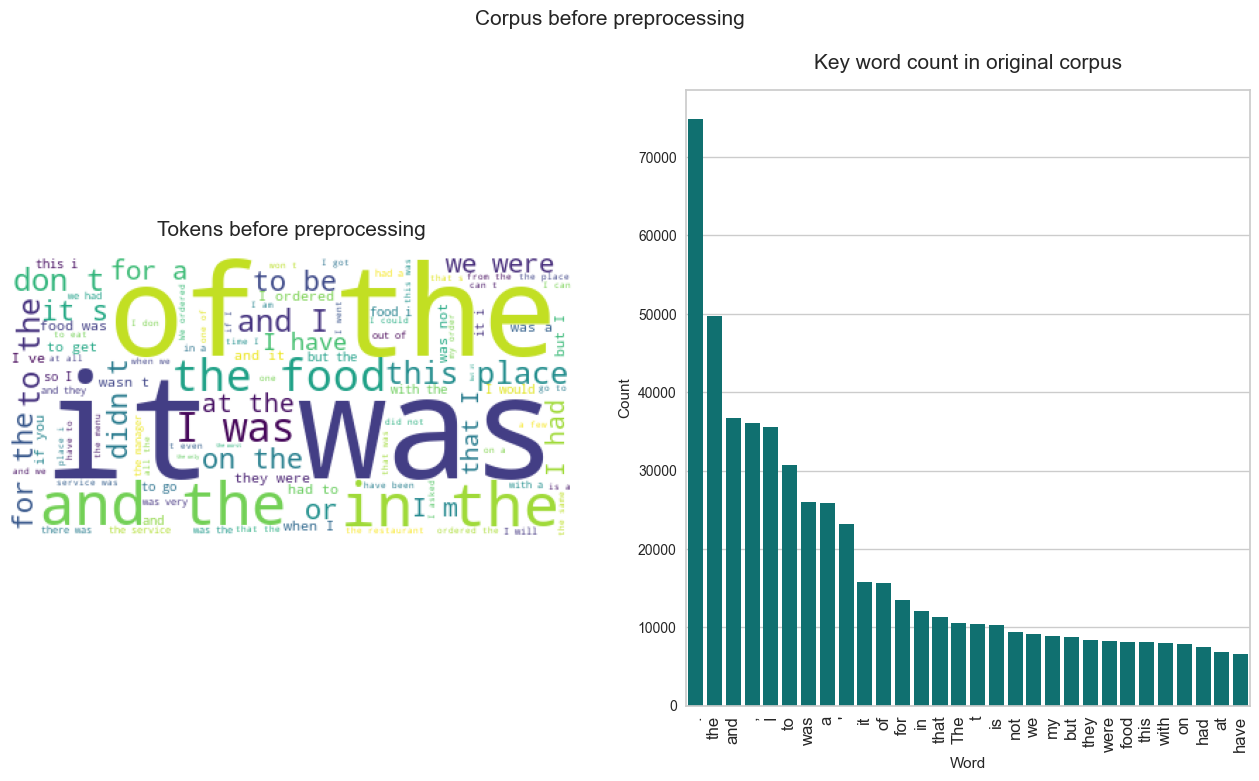

In [7]:
display_original_corpus_info(data)

### 1. B. Our corpus of reviews after cleaning

There is a clear improvement in our corpus since we now only have restaurant-related words which can be used by our model to detect the topics.

Number of tokens: 195194, Number of unique tokens: 9748
['disgrace' 'franchise' 'fast' 'restaurant' 'mess' 'operation'
 'girlfriend' 'night' 'snack' 'thru' 'hour' 'order' 'cash' 'consideration'
 'sign' 'customer' 'line' 'situation' 'fact' 'location' 'turn'
 'restaurant' 'fast' 'experience' 'experience' 'line' 'hour' 'recreate'
 'experience' 'stick']


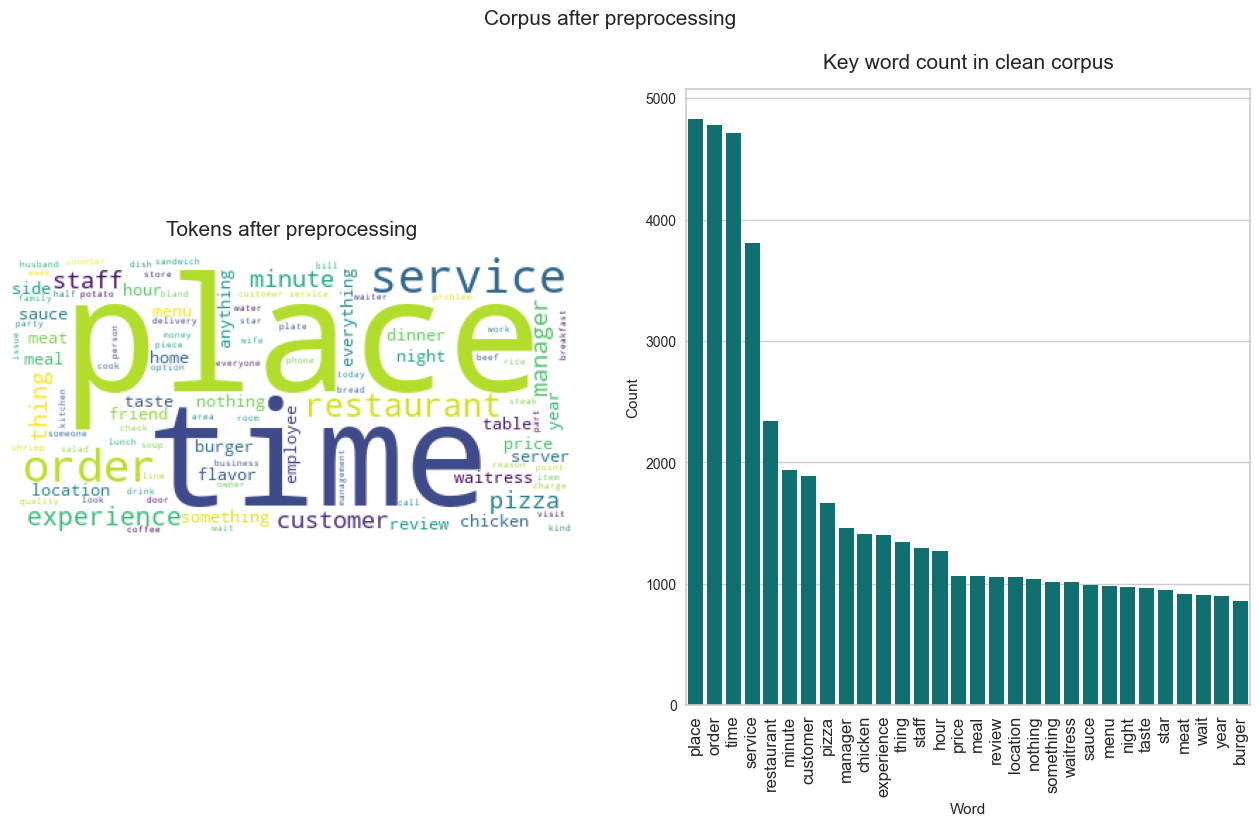

In [15]:
display_clean_corpus_info(data)

## 2. Training the LDA model

The LDA or the Latent Dirichlet Allocation model will allow us to detect topics in our reviews, sets of words that cluster together and have a higher probability to appear together in a review.  

At first we will use a smaller sample of 1000 of the reviews in order to calculate the ideal number of topics, after which we will give our final model 5000 reviews to have the most precision in our topics.

In [32]:
data_sample = data.sample(n=1000, replace=False)
data_sample = data_sample.reset_index()
data_sample.drop(columns=["index"], inplace=True)

### 2. A. Number of topics for the model

In order to calculate the ideal number of topics, we check the coherence score of our model. We have the option of using u_mass coherence, which is faster computationally but less accurate or to use c_v, which is slower but more accurate. I decided to use a sample of 1000 reviews and calculate the c_v, which explains the apparently lower than expected score. If we were to take a larger sample size or use the whole dataset of reviews, our c_v score would be much higher.

In [33]:
# Create Dictionary
id2word = corpora.Dictionary(data_sample.clean_text)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_sample.clean_text]

topics = []
coherence = []

for t in range(3, 7):

    lda = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=t,
        alpha=50 / t,
        eta=0.1,
        per_word_topics=True,
    )

    coherence_model_lda = CoherenceModel(
        model=lda, texts=data_sample.clean_text, dictionary=id2word, coherence="c_v"
    )
    coherence_lda = coherence_model_lda.get_coherence()

    topics.append(t)
    coherence.append(coherence_lda)

results = pd.DataFrame(columns=["Topics", "Coherence"])
results["Topics"] = topics
results["Coherence"] = coherence

Text(0, 0.5, 'Coherence score (c_v)')

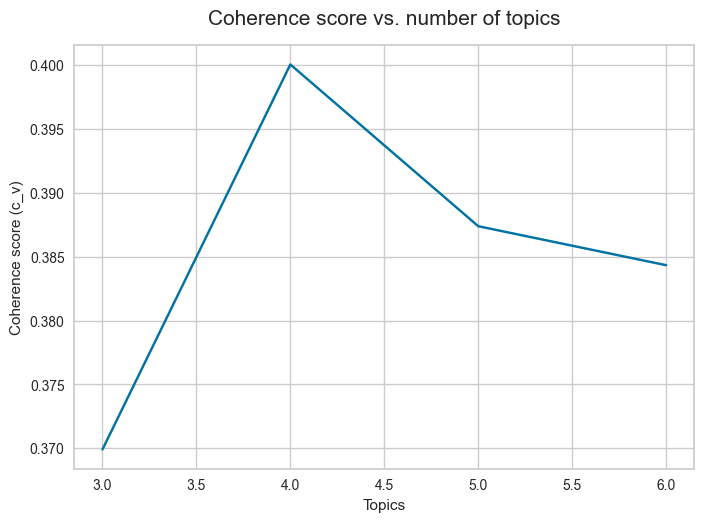

In [34]:
ax = sns.lineplot(results, x=topics, y=coherence)
ax.set_title("Coherence score vs. number of topics", fontsize=15, pad=15)
ax.set_xlabel("Topics")
ax.set_ylabel("Coherence score (c_v)")

### 2. B. LDA Gensim with the final number of topics

Now that we have decided on 4 topics, the area of the graph where we see a clear elbow, we will use our final LDA model with 5000 reviews.

In [35]:
data_sample = data.sample(n=5000, replace=False)
data_sample = data_sample.reset_index()
data_sample.drop(columns=["index"], inplace=True)

In [37]:
# Create Dictionary
id2word = corpora.Dictionary(data_sample.clean_text)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_sample.clean_text]

lda = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=4,
    chunksize=100,  # number of documents to consider at once
    minimum_probability=0.01,  #  minimum probability of word in topic
    passes=100,  # how many times the algorithm passes over the whole corpus
    alpha=50 / 4,  #
    eta=0.1,
    per_word_topics=True,
)  # every word assigned a topic, otherwise omitted
lda.print_topics()

[(0,
  '0.100*"time" + 0.049*"restaurant" + 0.040*"minute" + 0.031*"experience" + 0.028*"thing" + 0.024*"meal" + 0.022*"waitress" + 0.021*"wait" + 0.020*"something" + 0.018*"dinner"'),
 (1,
  '0.098*"place" + 0.028*"staff" + 0.024*"nothing" + 0.022*"review" + 0.022*"price" + 0.021*"night" + 0.020*"year" + 0.019*"star" + 0.018*"money" + 0.018*"anything"'),
 (2,
  '0.028*"chicken" + 0.021*"menu" + 0.021*"sauce" + 0.018*"taste" + 0.017*"meat" + 0.017*"lunch" + 0.016*"side" + 0.016*"rice" + 0.016*"flavor" + 0.015*"salad"'),
 (3,
  '0.098*"order" + 0.077*"service" + 0.041*"customer" + 0.038*"pizza" + 0.029*"manager" + 0.028*"hour" + 0.023*"location" + 0.016*"owner" + 0.016*"employee" + 0.014*"business"')]

### pyLDAvis visualization of the intertopic distance and top-30 most relevant terms per topic

In [38]:
pyLDAvis.gensim_models.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.256362  0.259360       1        1  25.441379
2      0.087674 -0.298019       2        1  25.139305
1      0.342092  0.192673       3        1  24.861991
3     -0.173405 -0.154014       4        1  24.557325, topic_info=           Term         Freq        Total Category  logprob  loglift
6         place  2381.000000  2381.000000  Default  30.0000  30.0000
37        order  2349.000000  2349.000000  Default  29.0000  29.0000
14         time  2524.000000  2524.000000  Default  28.0000  28.0000
10      service  1838.000000  1838.000000  Default  27.0000  27.0000
74   restaurant  1210.000000  1210.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
967        help   145.416273   145.725712   Topic4  -5.1057   1.4020
331       month   143.817648   144.127088   Topic4  -5.1167   1.4020
710        deal   139.197968   139.507423   Topic4  -5.1494   1.4019
11      someone   290.525975   362.063225   Topic4  -4.4136   1.1840
102        home   154.577455   351.683282   Topic4  -5.0446   0.5821

[155 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
108       3  0.999872  anything
27        3  0.998484      area
160       2  0.998080     bacon
299       2  0.997464      beef
501       1  0.996916      beer
...     ...       ...       ...
245       1  0.999464     water
80        3  0.998008      week
407       1  0.999511      wife
15        4  0.998448      work
49        3  0.998877      year

[128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

### WordClouds per topic

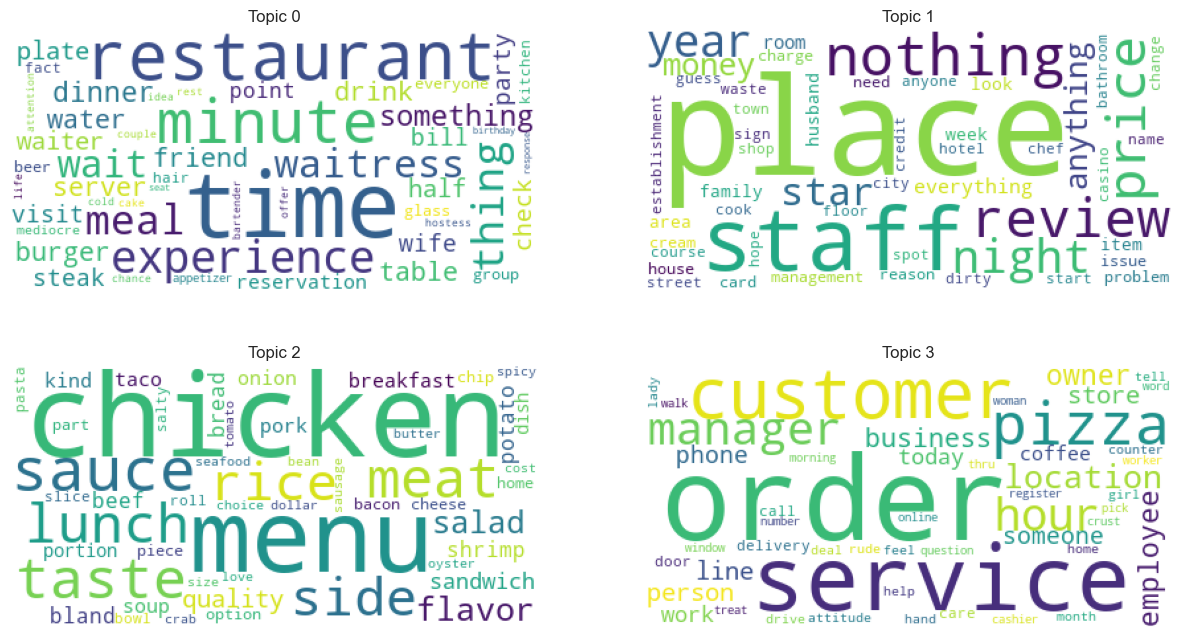

In [39]:
print_topic_wordclouds(lda)

## 3. Conclusion

We can see four clear topics emerge: 
1. Dissatisfaction about the experience, the wait, the order, the service.
2. Dissatisfaction about the restaurant, the cost and the quality (cost, dirty, look, waste, money).
3. Dissatisfaction about the meal, the menu, the taste of the food (flavor, mediocre, many food items).
4. Dissatisfaction about the employees, the manager, the owner (attitude, rude).